<a href="https://colab.research.google.com/github/vinay5751/object_detection/blob/main/rcnn_object_detetctor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data will be imported using GitHub repository of Dat Tran.
Code explaination here.

https://www.pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/

In [1]:
!git clone https://github.com/datitran/raccoon_dataset.git

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 652, done.
remote: Total 652 (delta 0), reused 0 (delta 0), pack-reused 652
Receiving objects: 100% (652/652), 48.01 MiB | 30.65 MiB/s, done.
Resolving deltas: 100% (415/415), done.


In [2]:
import os
from bs4 import BeautifulSoup
from imutils import paths
import cv2

In [3]:
# define the base path to the *original* input dataset and then use
# the base path to derive the image and annotations directories
ORIG_BASE_PATH = "/content/raccoon_dataset"
ORIG_IMAGES = os.path.sep.join([ORIG_BASE_PATH, "images"])
ORIG_ANNOTS = os.path.sep.join([ORIG_BASE_PATH, "annotations"])
# define the base path to the *new* dataset after running our dataset
# builder scripts and then use the base path to derive the paths to
# our output class label directories
BASE_PATH = "/content/dataset"
POSITVE_PATH = os.path.sep.join([BASE_PATH, "raccoon"])
NEGATIVE_PATH = os.path.sep.join([BASE_PATH, "no_raccoon"])
# define the number of max proposals used when running selective
# search for (1) gathering training data and (2) performing inference
MAX_PROPOSALS = 2000
MAX_PROPOSALS_INFER = 200
# define the maximum number of positive and negative images to be
# generated from each image
MAX_POSITIVE = 30
MAX_NEGATIVE = 10
# initialize the input dimensions to the network
INPUT_DIMS = (224, 224)
# define the path to the output model and label binarizer
MODEL_PATH = "raccoon_detector.h5"
ENCODER_PATH = "label_encoder.pickle"
# define the minimum probability required for a positive prediction
# (used to filter out false-positive predictions)
MIN_PROBA = 0.99

In [4]:
def compute_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [5]:
for dirPath in (POSITVE_PATH, NEGATIVE_PATH):
	# if the output directory does not exist yet, create it
	if not os.path.exists(dirPath):
		os.makedirs(dirPath)
# grab all image paths in the input images directory
imagePaths = list(paths.list_images(ORIG_IMAGES))
# initialize the total number of positive and negative images we have
# saved to disk so far
totalPositive = 0
totalNegative = 0

In [6]:
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# show a progress report
	print("[INFO] processing image {}/{}...".format(i + 1,
		len(imagePaths)))
	# extract the filename from the file path and use it to derive
	# the path to the XML annotation file
	filename = imagePath.split(os.path.sep)[-1]
	filename = filename[:filename.rfind(".")]
	annotPath = os.path.sep.join([ORIG_ANNOTS,
		"{}.xml".format(filename)])
	# load the annotation file, build the soup, and initialize our
	# list of ground-truth bounding boxes
	contents = open(annotPath).read()
	soup = BeautifulSoup(contents, "html.parser")
	gtBoxes = []
	# extract the image dimensions
	w = int(soup.find("width").string)
	h = int(soup.find("height").string)
 	# loop over all 'object' elements
	for o in soup.find_all("object"):
		# extract the label and bounding box coordinates
		label = o.find("name").string
		xMin = int(o.find("xmin").string)
		yMin = int(o.find("ymin").string)
		xMax = int(o.find("xmax").string)
		yMax = int(o.find("ymax").string)
		# truncate any bounding box coordinates that may fall
		# outside the boundaries of the image
		xMin = max(0, xMin)
		yMin = max(0, yMin)
		xMax = min(w, xMax)
		yMax = min(h, yMax)
		# update our list of ground-truth bounding boxes
		gtBoxes.append((xMin, yMin, xMax, yMax))
	# load the input image from disk
	image = cv2.imread(imagePath)
	# run selective search on the image and initialize our list of
	# proposed boxes
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)
	ss.switchToSelectiveSearchFast()
	rects = ss.process()
	proposedRects= []
	# loop over the rectangles generated by selective search
	for (x, y, w, h) in rects:
		# convert our bounding boxes from (x, y, w, h) to (startX,
		# startY, startX, endY)
		proposedRects.append((x, y, x + w, y + h))
	# initialize counters used to count the number of positive and
	# negative ROIs saved thus far
	positiveROIs = 0
	negativeROIs = 0
	# loop over the maximum number of region proposals
	for proposedRect in proposedRects[:MAX_PROPOSALS]:
		# unpack the proposed rectangle bounding box
		(propStartX, propStartY, propEndX, propEndY) = proposedRect
		# loop over the ground-truth bounding boxes
		for gtBox in gtBoxes:
			# compute the intersection over union between the two
			# boxes and unpack the ground-truth bounding box
			iou = compute_iou(gtBox, proposedRect)
			(gtStartX, gtStartY, gtEndX, gtEndY) = gtBox
			# initialize the ROI and output path
			roi = None
			outputPath = None
			# check to see if the IOU is greater than 70% *and* that
			# we have not hit our positive count limit
			if iou > 0.7 and positiveROIs <= MAX_POSITIVE:
				# extract the ROI and then derive the output path to
				# the positive instance
				roi = image[propStartY:propEndY, propStartX:propEndX]
				filename = "{}.png".format(totalPositive)
				outputPath = os.path.sep.join([POSITVE_PATH,
					filename])
				# increment the positive counters
				positiveROIs += 1
				totalPositive += 1
			# determine if the proposed bounding box falls *within*
			# the ground-truth bounding box
			fullOverlap = propStartX >= gtStartX
			fullOverlap = fullOverlap and propStartY >= gtStartY
			fullOverlap = fullOverlap and propEndX <= gtEndX
			fullOverlap = fullOverlap and propEndY <= gtEndY
			# check to see if there is not full overlap *and* the IoU
			# is less than 5% *and* we have not hit our negative
			# count limit
			if not fullOverlap and iou < 0.05 and \
				negativeROIs <= MAX_NEGATIVE:
				# extract the ROI and then derive the output path to
				# the negative instance
				roi = image[propStartY:propEndY, propStartX:propEndX]
				filename = "{}.png".format(totalNegative)
				outputPath = os.path.sep.join([NEGATIVE_PATH,
					filename])
				# increment the negative counters
				negativeROIs += 1
				totalNegative += 1
			# check to see if both the ROI and output path are valid
			if roi is not None and outputPath is not None:
				# resize the ROI to the input dimensions of the CNN
				# that we'll be fine-tuning, then write the ROI to
				# disk
				roi = cv2.resize(roi, INPUT_DIMS,
					interpolation=cv2.INTER_CUBIC)
				cv2.imwrite(outputPath, roi)

[INFO] processing image 1/200...
[INFO] processing image 2/200...
[INFO] processing image 3/200...
[INFO] processing image 4/200...
[INFO] processing image 5/200...
[INFO] processing image 6/200...
[INFO] processing image 7/200...
[INFO] processing image 8/200...
[INFO] processing image 9/200...
[INFO] processing image 10/200...
[INFO] processing image 11/200...
[INFO] processing image 12/200...
[INFO] processing image 13/200...
[INFO] processing image 14/200...
[INFO] processing image 15/200...
[INFO] processing image 16/200...
[INFO] processing image 17/200...
[INFO] processing image 18/200...
[INFO] processing image 19/200...
[INFO] processing image 20/200...
[INFO] processing image 21/200...
[INFO] processing image 22/200...
[INFO] processing image 23/200...
[INFO] processing image 24/200...
[INFO] processing image 25/200...
[INFO] processing image 26/200...
[INFO] processing image 27/200...
[INFO] processing image 28/200...
[INFO] processing image 29/200...
[INFO] processing image

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tensorflow.keras.models import load_model
import imutils

In [28]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 9
BS = 32

In [29]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class labels
print("[INFO] loading images...")
imagePaths = list(paths.list_images(BASE_PATH))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=INPUT_DIMS)
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

[INFO] loading images...


In [30]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [31]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [32]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/9
93/93 [==============================] - 33s 326ms/step - loss: 0.4472 - accuracy: 0.8172 - val_loss: 0.0593 - val_accuracy: 0.9973
Epoch 2/9
93/93 [==============================] - 30s 321ms/step - loss: 0.0650 - accuracy: 0.9922 - val_loss: 0.0234 - val_accuracy: 0.9973
Epoch 3/9
93/93 [==============================] - 30s 318ms/step - loss: 0.0378 - accuracy: 0.9926 - val_loss: 0.0151 - val_accuracy: 0.9973
Epoch 4/9
93/93 [==============================] - 30s 321ms/step - loss: 0.0225 - accuracy: 0.9947 - val_loss: 0.0118 - val_accuracy: 0.9973
Epoch 5/9
93/93 [==============================] - 30s 319ms/step - loss: 0.0230 - accuracy: 0.9953 - val_loss: 0.0136 - val_accuracy: 0.9973
Epoch 6/9
93/93 [==============================] - 29s 317ms/step - loss: 0.0157 - accuracy: 0.9976 - val_loss: 0.0090 - val_accuracy: 0.9973
Epoch 7/9
93/93 [==============================] - 30s 317ms/step - loss: 0.0163 - accuracy: 0.996

In [33]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

  no_raccoon       1.00      1.00      1.00       440
     raccoon       0.99      1.00      1.00       308

    accuracy                           1.00       748
   macro avg       1.00      1.00      1.00       748
weighted avg       1.00      1.00      1.00       748



In [34]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving mask detector model...
[INFO] saving label encoder...


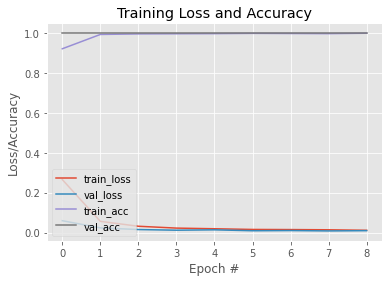

In [35]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [36]:
# load the our fine-tuned model and label binarizer from disk
print("[INFO] loading model and label binarizer...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(ENCODER_PATH, "rb").read())
# load the input image from disk
image = cv2.imread("/content/raccoon_dataset/images/raccoon-42.jpg")
image = imutils.resize(image, width=500)
# run selective search on the image to generate bounding box proposal
# regions
print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

[INFO] loading model and label binarizer...
[INFO] running selective search...


In [37]:
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:MAX_PROPOSALS_INFER]:
	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to the required input
	# dimensions of our trained CNN
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, INPUT_DIMS,
		interpolation=cv2.INTER_CUBIC)
	# further preprocess the ROI
	roi = img_to_array(roi)
	roi = preprocess_input(roi)
	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))

In [38]:
# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))
# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals)

[INFO] proposal shape: (200, 224, 224, 3)
[INFO] classifying proposals...


In [39]:
# find the index of all predictions that are positive for the
# "raccoon" class
print("[INFO] applying NMS...")
labels = lb.classes_[np.argmax(proba, axis=1)]
idxs = np.where(labels == "raccoon")[0]
# use the indexes to extract all bounding boxes and associated class
# label probabilities associated with the "raccoon" class
boxes = boxes[idxs]
proba = proba[idxs][:, 1]
# further filter indexes by enforcing a minimum prediction
# probability be met
idxs = np.where(proba >= MIN_PROBA)
boxes = boxes[idxs]
proba = proba[idxs]

[INFO] applying NMS...


In [40]:
from google.colab.patches import cv2_imshow

Before NMS


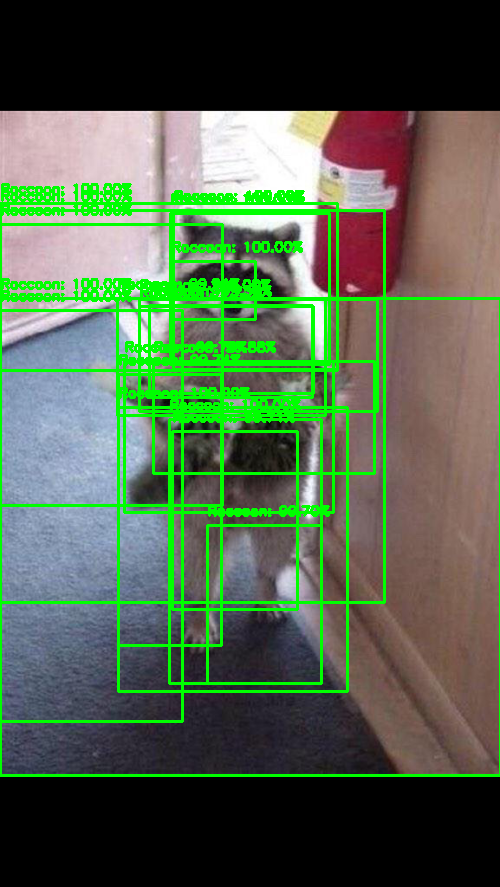

In [41]:
# clone the original image so that we can draw on it
clone = image.copy()
# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = box
	cv2.rectangle(clone, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Raccoon: {:.2f}%".format(prob * 100)
	cv2.putText(clone, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output after *before* running NMS
print("Before NMS")
cv2_imshow( clone)

In [42]:
'''# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")'''

'# Malisiewicz et al.\ndef non_max_suppression_fast(boxes, overlapThresh):\n\t# if there are no boxes, return an empty list\n\tif len(boxes) == 0:\n\t\treturn []\n\t# if the bounding boxes integers, convert them to floats --\n\t# this is important since we\'ll be doing a bunch of divisions\n\tif boxes.dtype.kind == "i":\n\t\tboxes = boxes.astype("float")\n\t# initialize the list of picked indexes\t\n\tpick = []\n\t# grab the coordinates of the bounding boxes\n\tx1 = boxes[:,0]\n\ty1 = boxes[:,1]\n\tx2 = boxes[:,2]\n\ty2 = boxes[:,3]\n\t# compute the area of the bounding boxes and sort the bounding\n\t# boxes by the bottom-right y-coordinate of the bounding box\n\tarea = (x2 - x1 + 1) * (y2 - y1 + 1)\n\tidxs = np.argsort(y2)\n\t# keep looping while some indexes still remain in the indexes\n\t# list\n\twhile len(idxs) > 0:\n\t\t# grab the last index in the indexes list and add the\n\t\t# index value to the list of picked indexes\n\t\tlast = len(idxs) - 1\n\t\ti = idxs[last]\n\t\tpick.app

In [43]:
'''#  Felzenszwalb et al.
def non_max_suppression_slow(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# initialize the list of picked indexes
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list, add the index
		# value to the list of picked indexes, then initialize
		# the suppression list (i.e. indexes that will be deleted)
		# using the last index
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		suppress = [last]
		# loop over all indexes in the indexes list
		for pos in range(0, last):
			# grab the current index
			j = idxs[pos]
			# find the largest (x, y) coordinates for the start of
			# the bounding box and the smallest (x, y) coordinates
			# for the end of the bounding box
			xx1 = max(x1[i], x1[j])
			yy1 = max(y1[i], y1[j])
			xx2 = min(x2[i], x2[j])
			yy2 = min(y2[i], y2[j])
			# compute the width and height of the bounding box
			w = max(0, xx2 - xx1 + 1)
			h = max(0, yy2 - yy1 + 1)
			# compute the ratio of overlap between the computed
			# bounding box and the bounding box in the area list
			overlap = float(w * h) / area[j]
			# if there is sufficient overlap, suppress the
			# current bounding box
			if overlap > overlapThresh:
				suppress.append(pos)
		# delete all indexes from the index list that are in the
		# suppression list
		idxs = np.delete(idxs, suppress)
	# return only the bounding boxes that were picked
	return boxes[pick]'''

'#  Felzenszwalb et al.\ndef non_max_suppression_slow(boxes, overlapThresh):\n\t# if there are no boxes, return an empty list\n\tif len(boxes) == 0:\n\t\treturn []\n\t# initialize the list of picked indexes\n\tpick = []\n\t# grab the coordinates of the bounding boxes\n\tx1 = boxes[:,0]\n\ty1 = boxes[:,1]\n\tx2 = boxes[:,2]\n\ty2 = boxes[:,3]\n\t# compute the area of the bounding boxes and sort the bounding\n\t# boxes by the bottom-right y-coordinate of the bounding box\n\tarea = (x2 - x1 + 1) * (y2 - y1 + 1)\n\tidxs = np.argsort(y2)\n \t# keep looping while some indexes still remain in the indexes\n\t# list\n\twhile len(idxs) > 0:\n\t\t# grab the last index in the indexes list, add the index\n\t\t# value to the list of picked indexes, then initialize\n\t\t# the suppression list (i.e. indexes that will be deleted)\n\t\t# using the last index\n\t\tlast = len(idxs) - 1\n\t\ti = idxs[last]\n\t\tpick.append(i)\n\t\tsuppress = [last]\n\t\t# loop over all indexes in the indexes list\n\t\tfor 

In [44]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes are integers, convert them to floats -- this
	# is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	# compute the area of the bounding boxes and grab the indexes to sort
	# (in the case that no probabilities are provided, simply sort on the
	# bottom-left y-coordinate)
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	# if probabilities are provided, sort on them instead
	if probs is not None:
		idxs = probs

	# sort the indexes
	idxs = np.argsort(idxs)

	# keep looping while some indexes still remain in the indexes list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the index value
		# to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of the bounding
		# box and the smallest (x, y) coordinates for the end of the bounding
		# box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have overlap greater
		# than the provided overlap threshold
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return only the bounding boxes that were picked
	return boxes[pick].astype("int")

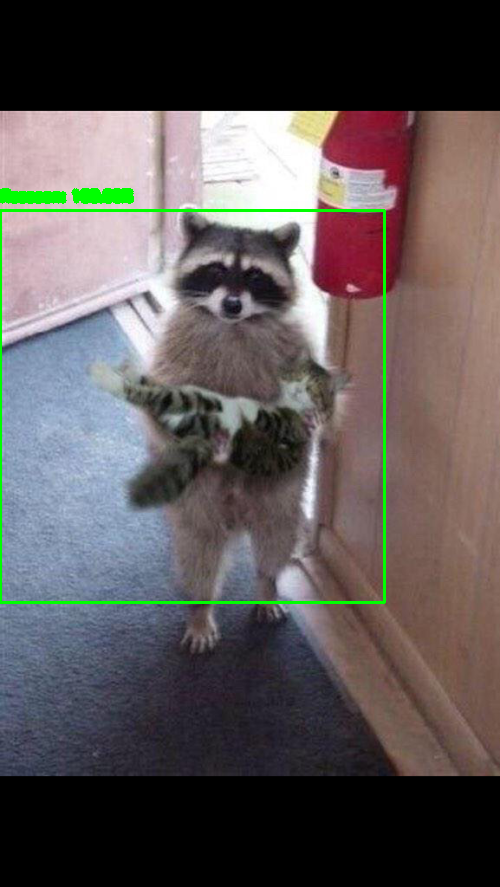

In [45]:
# run non-maxima suppression on the bounding boxes
boxIdxs = non_max_suppression(boxes, proba)
# loop over the bounding box indexes
for i in boxIdxs:
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = i
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	#text= "Raccoon: {:.2f}%".format(proba[i] * 100)
	image = cv2.putText(image, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 5)
# show the output image *after* running NMS
cv2_imshow(image)